# Solve 2d Poisson equation by PINN and a splitting scheme

---



### Domain:  $D=[0,1]^2$ 
### PDE
$$
\begin{aligned}
   \Delta u =& f\,\quad \mbox{in}\, D \\
   u|_{\partial D} =& g\quad \mbox{on}\, \partial D
   \end{aligned}
$$

### Aim: 
The boundary condition brings a constraint to the training task. 
The code below tests the splitting method in solving this PDE task. 

### Splitting scheme:

Suppose we want to solve
$$
    \min_{x} F(x), \quad s.t.\, G(x) = 0
$$

The splitting algorithm iterates the following two steps:

Step 1: Update $x^{n}$ to get $x^{n+1/2}$, using one-step update of the unconstrained optimization task:
$$
    \min_{x} F(x)
$$
Step 2: Starting from $x^{n+1/2}$, find $x^{n+1}$ by solving 
$$
    \min_{x} |G(X)|^2. 
$$ 


In [34]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import torch
import math 
import torch.nn as nn
import random
import itertools 
from tqdm import tqdm
import os
import time
import copy

class ConstrainedOptimizer():
    r"""This class solves the constraint
    """
    def __init__(self, model, problem, optimizer, batch_size=100, resampling=False, res_tol=1e-2, max_iter_steps=100, alpha=0.0, verbose=True):
        self.res_tol = res_tol
        self.max_iter_steps = max_iter_steps
        self.verbose = verbose
        self.model = model
        self.optimizer = optimizer
        self.batch_size = batch_size
        self.problem = problem
        self.resampling = resampling
        self.alpha = alpha
            
    def train(self):
        
        self.iter_steps = 0    
        loss_list = []
        init_params = [param.detach().clone() for param in model.parameters()]
        
        while self.iter_steps < self.max_iter_steps:
            
            if self.resampling or self.iter_steps == 0:
                self.problem.sample_Y_batch(self.batch_size)
                
            g_val = self.problem.G(self.model)
#            print ('step=', self.iter_steps, g_val)

            dist_loss = 0 
            for idx, param in enumerate(self.model.parameters()):
                dist_loss = dist_loss + ((param-init_params[idx])**2).mean()
                
            loss = g_val + self.alpha * dist_loss
                
            loss_list.append(loss)    
            if torch.linalg.norm(g_val) < self.res_tol:
                self.converged = True
                break
                
            self.optimizer.zero_grad()               
            loss.backward()
            self.optimizer.step()

#            self.optimizer.step(lambda: self.problem.G(self.model))
            self.iter_steps += 1
                        
        return loss_list
    
    def is_succeed(self):
        return self.converged
    
    def total_iter_steps(self):
        return self.iter_steps

    def projection(self):
        return self.train()


training starts, 1000 iterations in total.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:04<00:00, 242.85it/s]


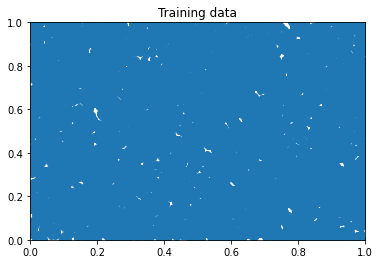

In [64]:
from test_problems import PoissonEqnByPINN, EigenPDE

n = 10000
n_bndry = 1000

batch_size = 1000
batch_size_bndry = 1000


# total number of learning steps
num_iters = 2000

# layers of the neural network.
layer_dims = [2, 30, 30, 1] 
optimizer_name = 'Adam'
learning_rate = 0.02
problem_id = 0

if problem_id == 0:
    problem = PoissonEqnByPINN(3.0, size=n, size_each_bndry=n_bndry)
else :
    # define the potential
    def V(x):
        return math.cos(x[0] * 4 * math.pi) + 3.0 * (x[1]-0.5)**2

    # define the eigenvalue PDE problem;
    # solve the first 2 eigenpairs
    problem = EigenPDE(V, 2.5, num_eig_funcs=2, eig_w=[1.0, 0.8], size=n, size_each_bndry=n_bndry)

# get training data
problem.sample_X_batch(1000)
X = problem.X

plt.scatter(X[:,0], X[:,1])
plt.xlim([0,1])
plt.ylim([0,1])
plt.title('Training data')

# create neural network that represents the solution of the PDE
model = problem.create_model(layer_dims)

train_losses = []
num_iters = 1000
print ("\ntraining starts, %d iterations in total." % num_iters)

# prepare optimizer 
if optimizer_name == 'Adam':
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
else:
    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate) 

# define another optimizer for solving the constraints
c_optimizer = torch.optim.Adam(model.parameters(), lr=0.002)
#c_optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.8, nesterov=True)       
#c_optimizer = torch.optim.LBFGS(model.parameters(), lr=0.05, history_size=10,tolerance_change=1e-3,
#                        max_iter=5, tolerance_grad=1e-03, line_search_fn="strong_wolfe")
    
copt = ConstrainedOptimizer(model, problem, c_optimizer, res_tol=0.01, resampling=True, max_iter_steps=100, alpha=0.0)

# use splitting scheme at the begining of the training
use_splitting_scheme_at_step = 0

for iter in tqdm(range(num_iters)):
    optimizer.zero_grad()    
    problem.sample_X_batch(batch_size)
    loss1 = problem.F(model)
    
    if iter < use_splitting_scheme_at_step: # penalty method 
        problem.sample_Y_batch(batch_size)
        loss2 = problem.G(model)
        loss = loss1 + 10.0 * loss2
        loss.backward()
        optimizer.step()
        csteps = 0 
    else :   # splitting method
        # Step 1: update by minimizing F
        loss1.backward()
        optimizer.step()
        # Step 2: projection by minimizing G (the constraints)
        closs_list = copt.projection()       
        loss2 = closs_list[-1]
        csteps = copt.total_iter_steps()
        
    if problem_id == 0: # Poisson
        X_batch = problem.get_X_batch()
        loss3 = ((model(X_batch) - problem.ref_u(X_batch))**2).mean()
    else:
        loss3 = None
        
    train_losses.append([loss1.detach().item(), loss2.detach().item(), csteps, loss3.detach()])
   

Losses:


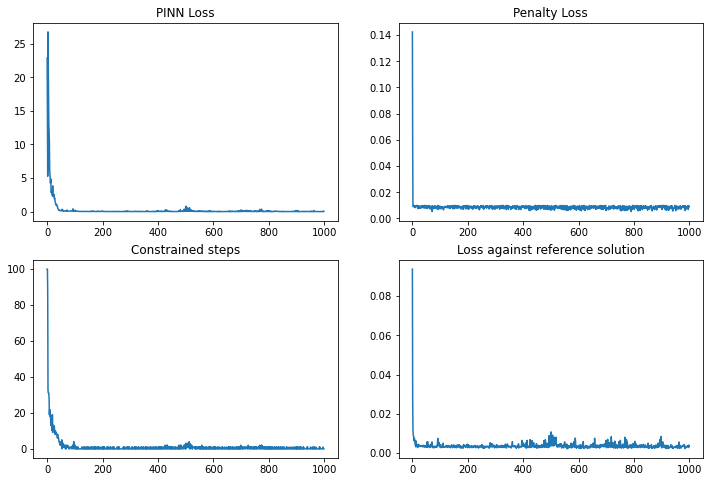

u:


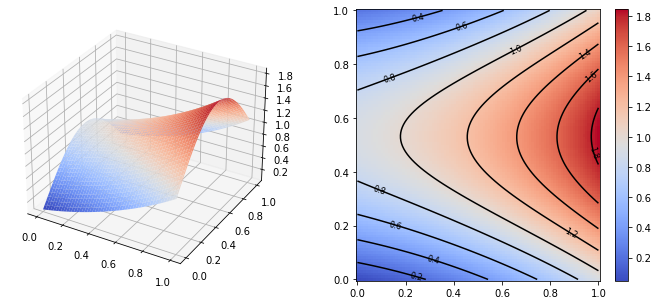

In [65]:
loss_list = np.array(train_losses)

ngrid = 100
grid1d = np.linspace(0, 1.0, ngrid)
x_plot = np.outer(grid1d, np.ones(ngrid)) 
y_plot = np.outer(grid1d, np.ones(ngrid)).T 

x2d = torch.from_numpy(np.concatenate((x_plot.reshape(ngrid * ngrid, 1), y_plot.reshape(ngrid * ngrid, 1)), axis=1)).float()

print ('Losses:')
fig, ax = plt.subplots(2,2, figsize=(12,8))
ax[0,0].plot(loss_list[:,0])
ax[0,0].set_title('PINN Loss')
ax[0,1].plot(loss_list[:,1])
ax[0,1].set_title('Penalty Loss')
ax[1,0].plot(loss_list[:,2])
ax[1,0].set_title('Constrained steps')
ax[1,1].plot(loss_list[:,3])
ax[1,1].set_title('Loss against reference solution')

plt.show()
fig_name = f'losses.jpg'
#fig.savefig(fig_name)
plt.close()

if problem_id == 0 : # Poisson equation
    print ('u:')

    u = model(x2d).detach().numpy()

    u = u.reshape(ngrid, ngrid)

    fig = plt.figure(figsize=(12,5))
    ax0 = fig.add_subplot(1, 2, 1, projection='3d')
    ax1 = fig.add_subplot(1, 2, 2)  
    ax0.plot_surface(x_plot, y_plot, u, cmap='coolwarm', edgecolor='none')
    im = ax1.pcolormesh(x_plot, y_plot, u, cmap='coolwarm',shading='auto')
    contours = ax1.contour(x_plot, y_plot, u, 10, colors='black')
    ax1.clabel(contours, inline=False, fontsize=8)
    fig.colorbar(im, ax=ax1)
    fig_name = f'u.jpg'
    #fig.savefig(fig_name)
    plt.show()
    #plt.close()
    
else :
    for idx in range(2):
        print (f'{idx}th eigenfunction:')

        u = model[idx](x2d).detach().numpy()

        u = u.reshape(ngrid, ngrid)

        fig = plt.figure(figsize=(12,5))
        ax0 = fig.add_subplot(1, 2, 1, projection='3d')
        ax1 = fig.add_subplot(1, 2, 2)  
        ax0.plot_surface(x_plot, y_plot, u, cmap='coolwarm', edgecolor='none')
        im = ax1.pcolormesh(x_plot, y_plot, u, cmap='coolwarm',shading='auto')
        contours = ax1.contour(x_plot, y_plot, u, 10, colors='black')
        ax1.clabel(contours, inline=False, fontsize=8)
        fig.colorbar(im, ax=ax1)
        fig_name = f'u.jpg'
        #fig.savefig(fig_name)
        plt.show()
        #plt.close()
